In [1]:
import sys
sys.path.append('../script')

In [2]:
import numpy as np
from pympler.asizeof import asizeof
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import gc

import get_dataset as ds
import preprocessing as pre
import constants


In [3]:
feats, dialects = ds.load_windowed_dataset()

Getting Ngadas: Marsam.wav 0.0
Getting Ngadas: Mas_Tom_Ngadas_201102.wav 0.0
Getting Banten: JWBP-20121229-A.wav 0.0
Getting Banten: JWBA-20100703-a.wav 0.0
Getting Banten: JWB-Banten_9.wav 0.0
Getting Banten: banten-2010-07-02-a.wav 0.0
Getting Banten: JWB-20090125.wav 0.0
Getting Banten: JWBP-20121229-B.wav 0.0
Getting Banten: JWB-Banten_10.wav 0.0
Getting Banten: JWB-20090126.wav 0.0
Getting Banten: JWB-20090116.wav 0.0
Getting Banten: JWB-Banten20100605-B.wav 0.0
Getting Banten: JWB-Banten_1.wav 0.0
Getting Banten: JWB-Banten_6.wav 0.0
Getting Banten: JWBA-20100703-b.wav 0.0
Getting Banten: JWB-Banten_4.wav 0.0
Getting Banten: JWB-20090117.wav 0.0
Getting Banten: JWB-20090118.wav 0.0
Getting Banten: JWB-Banten_8.wav 0.0
Getting Banten: JWB-20090131.wav 0.0
Getting Banten: JWB-20090130.wav 0.0
Getting Banten: JWB-Banten_11.wav 0.0
Getting Banten: JWB-Banten_5.wav 0.0
Getting Banten: JWB-20090123.wav 0.0
Getting Banten: JWB-20090124.wav 0.0
Getting Banten: JWB-20090127.wav 0.0
Gettin

In [4]:
feats.shape

(19842, 128, 150, 1)

In [5]:
# One-hot encoding of dialects
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(handle_unknown='error')
onehot.fit(dialects)

dialects_onehot = onehot.transform(dialects).toarray().tolist()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feats,
    dialects,
    train_size=0.8,
    random_state=42
)

y_train = onehot.transform(y_train.reshape((-1, 1))).toarray()
y_test = onehot.transform(y_test.reshape((-1, 1))).toarray()

In [7]:
import gc

del dialects, feats
gc.collect()

0

In [8]:
import tensorflow as tf
tf.keras.backend.clear_session()

def create_model(
    feature='mel_spectrogram',
    arch='vgg19',
    base_neuron=32,
    classes=len(constants.DIALECTS)
):
    """Creates a TensorFlow model.

    Args:
        feature (str, optional): Audio feature used. Defaults to 'mel_spec'.
        arch (str, optional): Architecture used. Defaults to 'cnn'.
    """
    _feat_amount = 128 if feature != 'mfcc' else 40
    _shape = (_feat_amount, constants.WINDOW_SIZE) + (1, )

    if arch == 'chatfield2014':   # Transfer Learning: VGG19
        model = tf.keras.Sequential([
            # conv1
            tf.keras.layers.Conv2D(96, (7, 7), 2, activation=tf.nn.relu, input_shape=_shape),
            tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, alpha=1e-4, beta=0.75, bias=2, depth_radius=5)),
            tf.keras.layers.MaxPooling2D(2, 2),
            # conv2
            tf.keras.layers.ZeroPadding2D(1),
            tf.keras.layers.Conv2D(256, (5, 5), 2, activation=tf.nn.relu),
            tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, alpha=1e-4, beta=0.75, bias=2, depth_radius=5)),
            tf.keras.layers.MaxPooling2D(2, 2),
            # conv3
            tf.keras.layers.ZeroPadding2D(1),
            tf.keras.layers.Conv2D(512, (3, 3), 1, activation=tf.nn.relu),
            # conv4
            tf.keras.layers.ZeroPadding2D(1),
            tf.keras.layers.Conv2D(512, (3, 3), 1, activation=tf.nn.relu),
            # conv5
            tf.keras.layers.ZeroPadding2D(1),
            tf.keras.layers.Conv2D(512, (3, 3), 1, activation=tf.nn.relu),
            tf.keras.layers.MaxPooling2D(2, 2),
            # full6
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5),
            # full7
            tf.keras.layers.Dense(4096, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5),
            # full8
            tf.keras.layers.Dense(16, activation=tf.nn.softmax)
        ])

    return model

In [9]:
model = create_model(arch='chatfield2014')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 72, 96)        4800      
                                                                 
 lambda (Lambda)             (None, 61, 72, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 36, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 32, 38, 96)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 17, 256)       614656    
                                                                 
 lambda_1 (Lambda)           (None, 14, 17, 256)       0

2022-01-28 19:16:16.699898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 19:16:16.734355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 19:16:16.734593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 19:16:16.735367: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=16)
    ]
)

In [11]:
# Checkpoint preparation

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../model/checkpoints/model_mel_spectrogram_chatfield2014_nb/',
    save_weights_only=True,
    verbose=1
)

In [12]:
# Training step.

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=200,
    validation_data=(X_test, y_test),
    steps_per_epoch=128,
    callbacks=[ckpt_callback]
)

2022-01-28 19:16:43.715523: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1219046400 exceeds 10% of free system memory.
2022-01-28 19:16:44.397070: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1219046400 exceeds 10% of free system memory.


Epoch 1/200


2022-01-28 19:16:47.426805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


128/128 [==============================] - ETA: 0s - loss: 2.1531 - categorical_accuracy: 0.2883 - precision: 0.6921 - recall: 0.0853 - f1_score: 0.0643

2022-01-28 19:17:15.910682: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 304819200 exceeds 10% of free system memory.
2022-01-28 19:17:16.109321: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 304819200 exceeds 10% of free system memory.



Epoch 00001: saving model to ../model/checkpoints/model_mel_spectrogram_chatfield2014_nb/
128/128 [==============================] - 38s 256ms/step - loss: 2.1531 - categorical_accuracy: 0.2883 - precision: 0.6921 - recall: 0.0853 - f1_score: 0.0643 - val_loss: 1.8789 - val_categorical_accuracy: 0.4301 - val_precision: 0.8153 - val_recall: 0.1212 - val_f1_score: 0.1407
Epoch 2/200
128/128 [==============================] - ETA: 0s - loss: 1.7717 - categorical_accuracy: 0.4432 - precision: 0.7694 - recall: 0.2061 - f1_score: 0.1520
Epoch 00002: saving model to ../model/checkpoints/model_mel_spectrogram_chatfield2014_nb/
128/128 [==============================] - 31s 243ms/step - loss: 1.7717 - categorical_accuracy: 0.4432 - precision: 0.7694 - recall: 0.2061 - f1_score: 0.1520 - val_loss: 1.6123 - val_categorical_accuracy: 0.4827 - val_precision: 0.8117 - val_recall: 0.2520 - val_f1_score: 0.1826
Epoch 3/200
128/128 [==============================] - ETA: 0s - loss: 1.5161 - categorica

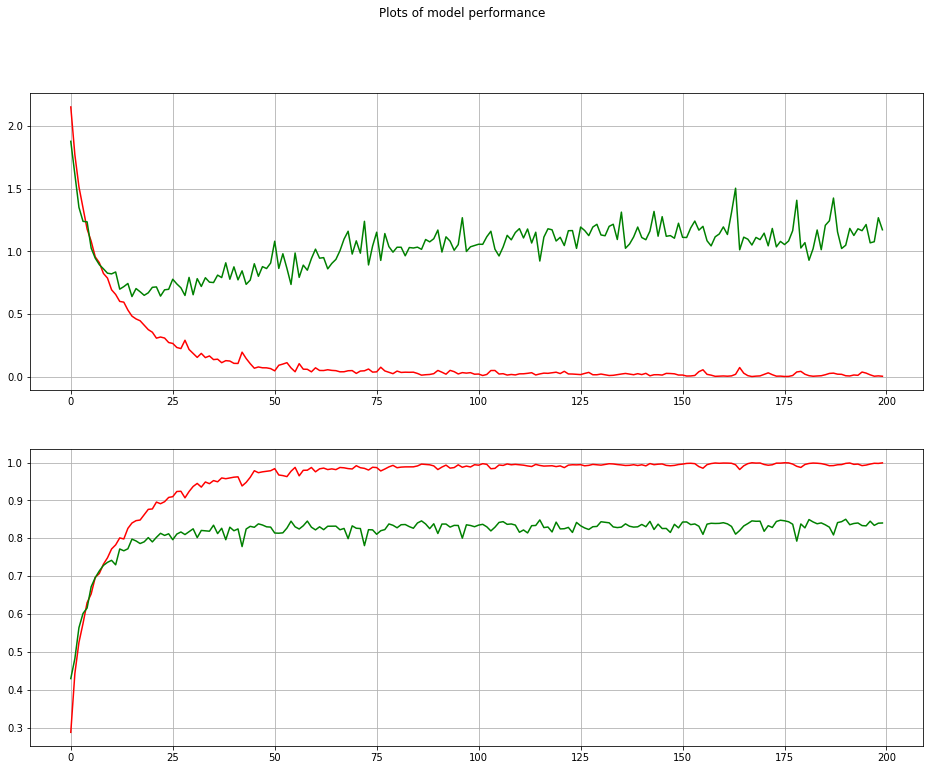

In [13]:
# Model visualisation - for now
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Plots of model performance')

ax[0].plot(history.history['loss'], 'r')
ax[0].plot(history.history['val_loss'], 'g')
ax[1].plot(history.history['categorical_accuracy'], 'r')
ax[1].plot(history.history['val_categorical_accuracy'], 'g')
ax[0].grid()
ax[1].grid()

plt.savefig('../visualization/performance/model-performance-chatfield.png')
plt.show()

In [14]:
metrics = model.evaluate(X_test, y_test)
print("""Model training validation result:
Loss\t\t: {},
Accuracy\t: {},
Precision\t: {},
Recall\t\t: {},

F1 score per categories:""".format(
    metrics[0], metrics[1], metrics[2], metrics[3]
))
for i in range(len(metrics[4])):
    print('\t' + onehot.categories_[0][i] + ':', str(metrics[4][i]))

2022-01-28 20:57:09.526721: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 304819200 exceeds 10% of free system memory.


125/125 [==============================] - 5s 35ms/step - loss: 1.1730 - categorical_accuracy: 0.8405 - precision: 0.8430 - recall: 0.8390 - f1_score: 0.7800
Model training validation result:
Loss		: 1.1730142831802368,
Accuracy	: 0.8405140042304993,
Precision	: 0.8430379629135132,
Recall		: 0.839002251625061,

F1 score per categories:
	Banten: 0.88265544
	Banyumas: 0.75739646
	Cirebon: 0.8853681
	Kediri: 0.82051283
	Lumajang: 0.7130435
	Madiun: 0.7676767
	Malang: 0.7616581
	Ngadas: 0.40816328
	Osing: 0.87058824
	Papua: 0.84931505
	Pemalang: 0.8604206
	Ranu Pane: 0.8353553
	Semarang: 0.9558233
	Solo: 0.83593756
	Tegal: 0.6605504
	Tengger: 0.61538464


In [15]:
# Saving model.
model.save('../model/model_mel_spec_chatfield2014_nb.h5')
model.save_weights('../model/weights/model_mel_spec_chatfield2014_nb/')